# Machine Learning, Excercise 3

* Attila Lazar 0026842
* Bogdan

In [1]:
import os
os.getcwd()
import matplotlib.pyplot as plt
os.chdir('/home/lazafi/labor/ml-2019/male2019/3/src/fruits')
os.getcwd()

import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from PIL import Image
from glob import glob
import csv
import seaborn as sn
import pandas as pd

#from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

from helper import *



## Feature Variables

### Pixel Data

Images are read as 3-tupples of color values raging from 0 to 255. We use cv2 library for reading images and to convert them in rgb arrays.

The reading of the Images is hidden in the Class FIDS30DataSet, we only pass the absolute root directory. For demonstration purposes we can also limit the number of classes and number of images per class.

In [2]:
# read is limited to 2 files from 2 subdirecories
fruit2data = FIDS30DataSet("/home/lazafi/labor/ml-2019/male2019/3/data/FIDS30", limit=2)


 category strawberries 2
 category apples 2


### Histogram

From the pixel data we extracted color histograms. For the color images we count the occurances for each 256 colors in each of the 3 channels seperatelly and concat them to a long histogram of 768 colors. We also provide the option to reduce the histogram to the given amount of bins.


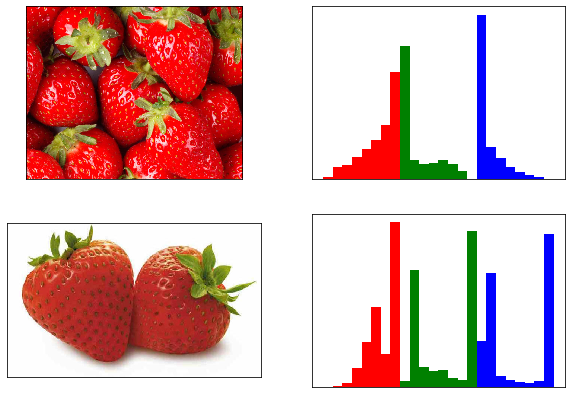

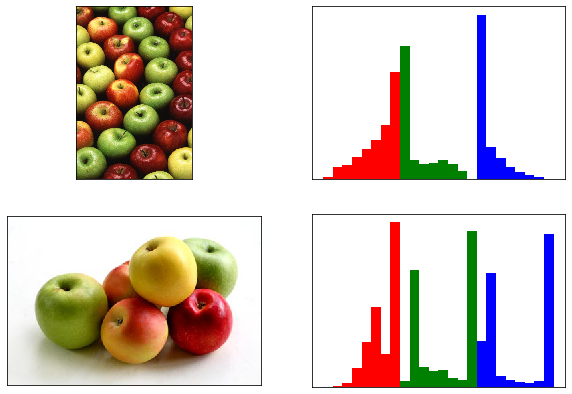

In [3]:
# we only use 10 bins per color channel
fruit2data.resetFeatures()
fruit2data.addFeatures(Histogram(8, debug=True))


### Visual Bag of Words

We use cv2 ORB implementation to describe features of images. First image Descriptor are extracted from all images. to reduce the amount of possible descriptors these are grouped using KMeans clustering (sklearn MiniBatchKMeans to save memory). These clustered descriptors are then counted for each image and a Histogram of the frequencies of these descriptors is used to train our 3 classifiers. 

We capsuled the code in class which we can pass to the dataset class to extract features. The parameter (10) is the amount to which the descriptors are reduced in the clustering process (number of clusters). 

In [4]:
#fruit2data.resetFeatures()
#fruit2data.addFeatures(BOV(10, debug = False))

## Classifiers

We used following classifiers from the sklearn library:

* Support Vector Machine Classifier
* knn Classifier
* Multi Layered Perceptron

From these "classic" classification methods we expect to achive our baseline performace. Then we will try to surpass this witch an deep convolutional neural network classifier setup. 


## Evaluation

For each experiment we divided our dataset in 67% training and 33% test images. For training we used the training set.

After training the model we used it on the test images to predict their class and computed the *confusion matrix* to visually inspect the accuracy of the classification. Additionaly we also use macro-averaged precission to compare between classifiers.

The code for evaluation is enclosed in the Experiment class method evaluate(). It can display confusion-matrix and print a detailed report about per class and overall accuracy. 

## FIDS30 Fruits Dataset

We used the FIDS30 dataset provided by the lecture. It consists of 30 directories containing ap. 30 images of one fruit.


### Historgam features


As a first experiment we extract Histogram Data from the Images and train different classifiers on this data to predict the kind of the fruit. 

In [ ]:
# prepare the fids30 dataset with histogram features
fids30_data = FIDS30DataSet("/home/lazafi/labor/ml-2019/male2019/3/data/FIDS30")
fids30_data.addFeatures(Histogram(8))
print(fids30_data.count)

 category strawberries 46
 category apples 38
 category raspberries 39
 category mangos 34
 category avocados 26
 category coconuts 26
 category apricots 30
 category grapefruits 31
 category watermelons 31
 category plums 31
 category peaches 27
 category grapes 38
 category kiwifruit 36


In [ ]:
print(fids30_data.labels)

### Support Vector Machines Classifier

The SVM Classifier gave us the poorest results. For most of the test images the model failed to predict the correct class, most of images got classified as pommegranates and cheries. 

In [ ]:
# svc

exp1 = Experiment(fids30_data, svm.SVC(gamma='auto'), "Histogram with SVC")
exp1.train()
exp1.evaluate(figure=True)


### k Nearest Neighbors classifier

We got better result using knn Classifier. Fruits with simular colors are most commonly missclassified: apples and cherries, watermelons and passionfruits. Some missclassifications are not as obvious like coconuts and oranges missclassified as avocados.

In [ ]:
# knn
exp1 = Experiment(fids30_data, KNeighborsClassifier(n_neighbors=3, weights = 'distance'),  "Histogram with Knn k=3")
exp1.train()
exp1.evaluate(figure=True, text=True)



#### diferent values for k

We tried to tune the performace with higher values for k. Different values for k only affect the precission marginaly, so we choose k=3 for better computability.

In [ ]:
score = []
for k in range(1, 20):
    #print(k)
    classifier = KNeighborsClassifier(n_neighbors=k, weights = 'distance')
    classifier.fit(exp1.x_train, exp1.y_train)
    predicted = classifier.predict(exp1.x_test)
    #print(predicted)
    #print(exp1.y_test)
    score.append(metrics.precision_score(exp1.y_test, predicted, average='macro'))
plt.figure(figsize=(10,10))
plt.plot(score)
plt.show()

#### Histogram size

Histogram size has a big impact on performace. We found lower values to be much better.

In [ ]:
score = []
xrange = range(8, 264, 32)
for h in xrange:
    #print(h)
    fids30_data.resetFeatures()
    fids30_data.addFeatures(Histogram(h))
    exp = Experiment(fids30_data, KNeighborsClassifier(n_neighbors=3, weights = 'distance'),  "%d Histogram with Knn k=%d" % (h, 10))
    exp.train()
    score.append(exp.precision())
print(score)
plt.figure(figsize=(20,10))
plt.plot(xrange, score)
plt.show()

### Multi Layered Perceptron

We achived the best performace on histogram data using mlp classifier. For some fruits like grapefruits and pommegrapes the performace was about 50%. Overall 28%. 

In [ ]:

# mlp
exp1 = Experiment(fids30_data,  MLPClassifier(max_iter=3200, verbose=False))
exp1.train()
exp1.evaluate(figure=True)


In [ ]:
exp1.evaluate(text=True)

### Visual Bag of Words

We repeat the experiments but instead of extracting histogram data from the images we extract Visual Descriptors. We then use this data to train different classifiers. As with traditional Histograms, BOV also counts the frequency of descriptors. As a parameter we can set the amount of descriptors we use to describe an image.

In [ ]:
# prepare dataset with bov features
fids30_data.resetFeatures()
fids30_data.addFeatures(BOV(20))


In [ ]:

# svc
exp1 = Experiment(fids30_data,  svm.SVC())
exp1.train()
exp1.evaluate(figure=True)


In [ ]:

# knn
exp1 = Experiment(fids30_data, KNeighborsClassifier(n_neighbors=3, weights = 'distance'))
exp1.train()
exp1.evaluate(figure=True)


In [ ]:

# mlp
exp1 = Experiment(fids30_data, MLPClassifier(max_iter=3200, verbose=False))
exp1.train()
exp1.evaluate(figure=True, text=True)


In [ ]:
### deep convolutional neural network

TODO

### Develop a Baseline CNN Model

In this section, we will develop a baseline Convolutional Neural Network model for the FIDS30 dataset.

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

We will use for starting point the general architectural principles of the VGG models. These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. 

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

We can create a function named define_model() that will define a model and return it ready to be fit on the dataset. This function can then be customized to define different baseline models, e.g. versions of the model with 1, 2, or 3 VGG style blocks.

The model will be fit with Stochastic Gradient Descent and we will start with a conservative learning rate of 0.001 and a momentum of 0.9.

### One Block VGG Model

The one-block VGG model has a single convolutional layer with 32 filters followed by a max pooling layer.

## Cars Data Set
   
The Cars Dataset contains Monochrome images. We classify these images wether there is a car in them or no car.   

In [ ]:
# prepare the car dataset with histogram features
#datapath = "/home/lazafi/labor/ml-2019/male2019/3/data/CarData"
car_data = CarDataSet()
car_data.loadImages("/home/lazafi/labor/ml-2019/male2019/3/data/CarData/TrainImages")
car_data.loadImages("/home/lazafi/labor/ml-2019/male2019/3/data/CarData/TestImages", "neg")
print(car_data.count)


### Histogram Data

Since the Images are monochrome, using histogram data is probably not as efficient as for the Fruits dataset.


In [ ]:
car_data.addFeatures(Histogram(10))

# knn
exp1 = Experiment(car_data, KNeighborsClassifier(n_neighbors=3, weights = 'distance'),  "Histogram with Knn k=3")
exp1.train()
exp1.evaluate(figure=True, text=True)


In [ ]:
# knn
exp1 = Experiment(car_data, svm.SVC(),  "Histogram with svm")
exp1.train()
exp1.evaluate(text=True)

exp1 = Experiment(car_data, MLPClassifier(max_iter=3200, verbose=False),  "Histogram with mlp")
exp1.train()
exp1.evaluate(text=True, figure=True)


As expected the performace of all classifiers is only slightly over the baseleine of 50%. Moreover, since the classes are unbalanced the classifiers are probably useles

### Visual Bag of Words

Using the VBOW approach we expect much better results. Using the MLPClassifier we achive ap 80% accuracy with only some  more "pos" images missclassified as "neg"

In [ ]:
car_data.resetFeatures()
car_data.addFeatures(BOV(30, debug=False))

# knn
exp1 = Experiment(car_data, KNeighborsClassifier(n_neighbors=3, weights = 'distance'))
exp1.train()
exp1.evaluate(figure=True, text=True)

# svm
exp1 = Experiment(car_data, svm.SVC())
exp1.train()
exp1.evaluate(figure=True, text=True)

# mlp
exp1 = Experiment(car_data, MLPClassifier())
exp1.train()
exp1.evaluate(figure=True, text=True)


#### size of the BOV Histogram

In [ ]:
score = []
xrange = range(10, 50, 10)
for h in xrange:
    print(h)
    car_data.resetFeatures()
    car_data.addFeatures(BOV(h))
    exp = Experiment(car_data, MLPClassifier(max_iter=3200, verbose=False),  "BOV(%d)" % h)
    exp.train()
    score.append(exp.precision())
print(score)
plt.figure(figsize=(20,10))
plt.plot(xrange, score)
plt.show()

## CNN

In [ ]:
# TODO
